In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from bresenham import bresenham
from numpy import matmul as mm
from tqdm import tqdm
from scipy.stats import mode
import math
import tqdm

data = sio.loadmat('practice.mat')
M = data['M']; init_pose = data['init_pose'];
pose = data['pose']; ranges = data['ranges']
scanAngles = data['scanAngles']; t = data['t']

In [2]:
param = {}
param['resol'], param['origin'] = 25, np.array([[685],[572]])
param['init_pose'] = -init_pose

Text(0.5, 1.0, 'Lidar measurement in the body frame')

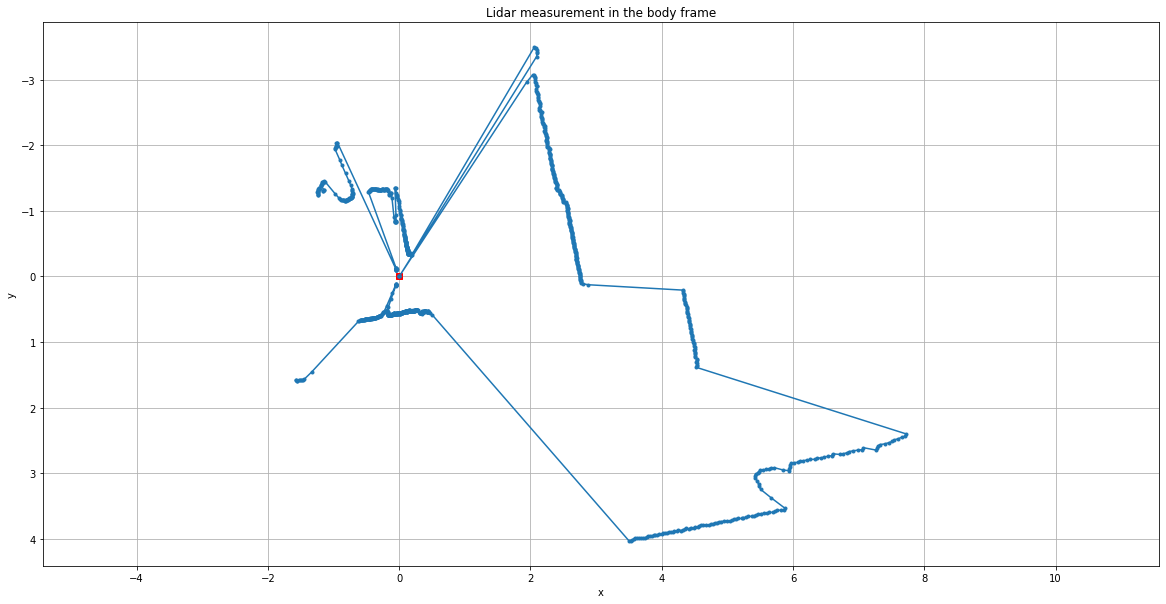

In [3]:
tmp1 = ranges[:,0].reshape(-1,1)*np.cos(scanAngles)
tmp2 = -ranges[:,0].reshape(-1,1)*np.sin(scanAngles)
lidar_local = np.hstack((tmp1,tmp2))
plt.figure(figsize=(20,10))
plt.plot(0,0,'rs')
plt.plot(lidar_local[:,0],lidar_local[:,1],'.-')
plt.axis('equal')
plt.gca().invert_yaxis()
plt.xlabel('x'); plt.ylabel('y')
plt.grid(True)
plt.title('Lidar measurement in the body frame')

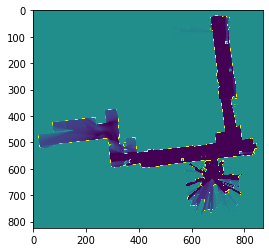

In [4]:
plt.imshow(M)

In [5]:
lidar_global = np.zeros((ranges.shape[0],2))
lidar_global[:,0]=np.array([(ranges[:,0]*np.cos(scanAngles+pose[2,0]).flatten()+
                      pose[0,0])*param['resol']+param['origin'][0]])
lidar_global[:,1]=np.array([(-ranges[:,0]*np.sin(scanAngles+pose[2,0]).flatten()+
                      pose[1,0])*param['resol']+param['origin'][1]])

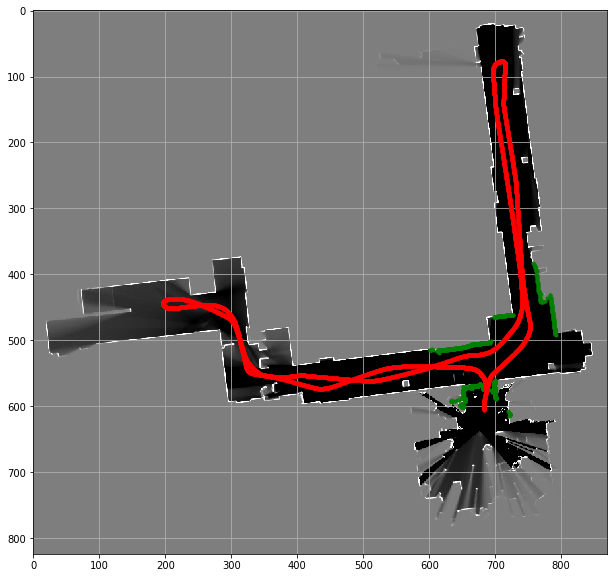

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(M,cmap='gray')
plt.plot(lidar_global[:,0],lidar_global[:,1],'g.')
plt.grid(True)
plt.plot(pose[0,:]*param['resol']+param['origin'][0],
        pose[1,:]*param['resol']+param['origin'][1],'r.-')

In [7]:
def particleLocalization(ranges,scanAngles,Map,param):
    N,M = ranges.shape[1],1200
    myPose = np.zeros((3,N))
    myResolution, myOrigin = param['resol'],param['origin']
    myPose[:,0] = param['init_pose'].flatten()
    map_threshold_low = mode(Map,None)[0] - .3
    map_threshold_high = mode(Map,None)[0] + .3
    resample_threshold,radius = .85,.048
    sigma_m = .029*np.array([[1],[1],[2]])
    direction = myPose[2,0]
    P = np.tile(myPose[:,0],(1,M))
    W = np.tile(1/M,(1,M))
    lidar_global = np.zeros((ranges.shape[0],2))
    
    for j in tqdm.tqdm(range(1,N)):
        P = np.tile(myPose[:,j-1].reshape(-1,1),(1,M))
        R = radius
        P += np.random.normal(0,1,(3,M))*(mm(sigma_m,np.ones((1,M))))
        P[0,:M] += R*np.cos(P[2,:M])
        P[1,:M] += R*np.sin(P[2,:M])
        W = np.tile(1/M,(1,M))
        P_corr = np.zeros((1,M))
        for i in range(M):
            lidar_global[:,0]=np.array([(ranges[:,j]*np.cos(scanAngles+P[2,i]).flatten()+
                      P[0,i])*myResolution+myOrigin[0]]).astype(int)
            lidar_global[:,1]=np.array([(-ranges[:,j]*np.sin(scanAngles+P[2,i]).flatten()+
                      P[1,i])*myResolution+myOrigin[1]]).astype(int)
            
            lidar_global[lidar_global[:,0]<1,0] = myOrigin[0]
            lidar_global[lidar_global[:,0]<1,1] = myOrigin[1]
            lidar_global[lidar_global[:,1]<1,0] = myOrigin[0]
            lidar_global[lidar_global[:,1]<1,1] = myOrigin[1]
            lidar_global[lidar_global[:,0]>Map.shape[1]-1,0] = myOrigin[0]
            lidar_global[lidar_global[:,0]>Map.shape[1]-1,1] = myOrigin[1]
            lidar_global[lidar_global[:,1]>Map.shape[0]-1,0] = myOrigin[0]
            lidar_global[lidar_global[:,1]>Map.shape[0]-1,1] = myOrigin[1]
            lidar_global = lidar_global.astype(int)
            corr_values = Map[lidar_global[:,1],lidar_global[:,0]]
            P_corr[0,i]=-3*np.sum(corr_values<=map_threshold_low)+10*np.sum(corr_values>=map_threshold_high)
        P_corr -= np.min(P_corr)
        
        W = W[:M]*P_corr/np.sum(P_corr)
        W /= np.sum(W)
        
        ind = np.argmax(W)
        myPose[:,j] = P[:,ind]
    
    return myPose

In [8]:
pose1 = particleLocalization(ranges[:,:1000],scanAngles,M,param)

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [02:36<00:00,  6.37it/s]


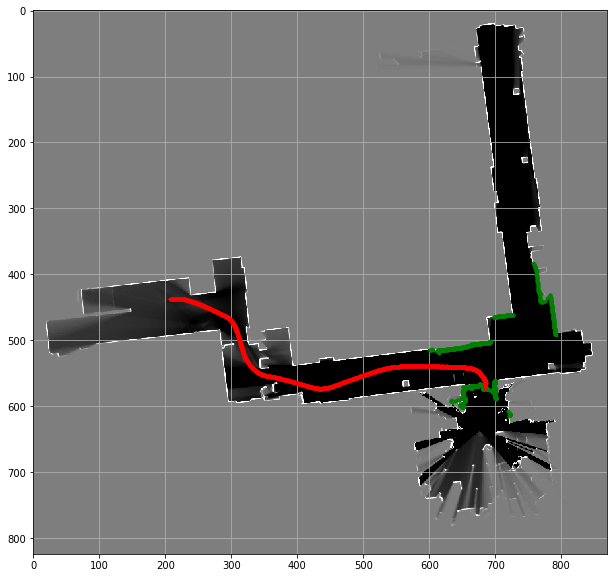

In [9]:
lidar_global = np.zeros((ranges.shape[0],2))
lidar_global[:,0]=np.array([(ranges[:,0]*np.cos(scanAngles+pose1[2,0]).flatten()+
                      pose1[0,0])*param['resol']+param['origin'][0]])
lidar_global[:,1]=np.array([(-ranges[:,0]*np.sin(scanAngles+pose1[2,0]).flatten()+
                      pose1[1,0])*param['resol']+param['origin'][1]])

plt.figure(figsize=(20,10))
plt.imshow(M,cmap='gray')
plt.plot(lidar_global[:,0],lidar_global[:,1],'g.')
plt.grid(True)
plt.plot(pose1[0,:]*param['resol']+param['origin'][0],
        pose1[1,:]*param['resol']+param['origin'][1],'r.-')